In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from collections import defaultdict # For easier subject counts
import operator
from tqdm.notebook import tqdm
import datetime
import re
import pickle
import random
# Optional: for better display in Jupyter
from IPython.display import display
from scipy.stats import truncnorm

In [152]:
df = pd.read_csv('ColocCotime_network_base.csv')
print("Loaded ColocCotime_network_base.csv with shape:", df.shape)
df.head()

Loaded ColocCotime_network_base.csv with shape: (11411, 693)


,College,Subject,Year,Social Propensity,Club Propensity,Disease State,Adapted Group Size,Gender,Assigned,Group ID,...,T_671,LectureSlots,StudyBudget,SocialBudget,OutdoorBudget,ShoppingBudget,SleepBudget,WeeklySocialBudgets,WeeklySocialBlocks,SleepRequirement
0,Christ's,Architecture Tripos,1,6,10,0,7,Male,True,1.0,...,Christ's College bar,27,133,80,16,12,218,"[26.666666666666664, 17.77777777777778, 17.777...","[[5, 5, 4, 4, 3, 3, 5, 4, 4], [6, 4, 4, 3, 3, ...",8
1,Christ's,Architecture Tripos,1,10,10,0,6,Female,True,2.0,...,Sleep,27,133,86,4,12,209,"[28.666666666666664, 19.11111111111111, 19.111...","[[6, 4, 6, 3, 4, 4, 5, 5, 2], [5, 3, 6, 5, 5, ...",8
2,Christ's,Architecture Tripos,2,6,6,0,4,Female,True,23.0,...,The Orator,18,142,44,32,12,197,"[14.666666666666666, 9.777777777777777, 9.7777...","[[4, 4, 5, 4, 3, 5], [4, 3, 4, 3, 5, 1], [5, 5...",7
3,Christ's,Architecture Tripos,2,5,9,0,5,Male,True,4.0,...,The Eagle,18,142,46,16,12,204,"[15.333333333333332, 10.222222222222221, 10.22...","[[5, 5, 3, 5, 3, 5], [4, 4, 6, 4, 3], [5, 5, 5...",6
4,Christ's,Architecture Tripos,3,6,5,0,6,Female,True,53.0,...,The Bath House,9,151,44,32,12,169,"[14.666666666666666, 9.777777777777777, 9.7777...","[[5, 5, 4, 5, 4, 2], [5, 6, 4, 5], [6, 4, 5, 5...",6


So now we have a data frame where we can infect an initial set of students. And watch the disease spread. So the method for this is. At T = 12 (skips teething problems of calender), infect 1% of students with one of 5 diseases A, B, C, D or E. If a student is not infected with a disease, their disease state should be 0. If they are infected with a disease, it should be the capital letter of the disease. Once the student is recovered, their disease state should be the lower case equivalent letter. I'm planning on using a SIR model for each timestep, where the local connection are the students that are co-spatial at that shared time. Begin by producing a Disease class with parameters: transmission rate (between 0 and 1), and recovery rate (likelihood of healing in that hour). Loading Location_popularity.csv provides every location with the number of people you a student comes in contact with while at that location in a given hour. Code up this disease class, and provide a SIR model framework -> moving from time step to time step, updating the assoicated disease column with the correct code. 



In [153]:
class Disease:
    def __init__(self, name, transmission_rate, recovery_rate):
        self.name = name  # e.g. 'A'
        self.transmission_rate = transmission_rate  # probability of infection per contact per hour
        self.recovery_rate = recovery_rate  # probability of recovery per hour

# Example: create 5 diseases
diseases = [
    Disease('A', transmission_rate=0.1, recovery_rate=0.01), #Students ill for on average, 5 days. 
    Disease('B', transmission_rate=0.05, recovery_rate=0.01),
    Disease('C', transmission_rate=0.02, recovery_rate=0.01),
    Disease('D', transmission_rate=0.015, recovery_rate=0.01),
    Disease('E', transmission_rate=0.01, recovery_rate=0.01),
    Disease('F', transmission_rate=0.005, recovery_rate=0.01),
]

In [154]:
# Load the base DataFrame
df = pd.read_csv('ColocCotime_network_base.csv')
# --- Load Location Popularity ---
# Assumes Location_popularity.csv has columns: Location, Hour, Popularity
loc_pop = pd.read_csv('Location_popularity.csv')
def get_contacts(loc, hour_of_day):
    try:
        return loc_pop.loc[loc_pop['Hour'] == hour_of_day, loc].values[0]
    except Exception:
        return 10  # fallback if missing
    
# Identify all disease state columns (or create them if not present)
time_cols = [col for col in df.columns if col.startswith('T_')]
for col in time_cols:
    disease_col = f'Disease_{col}'
    df[disease_col] = '0' * len(diseases)     # Set all disease state columns to '00000' (all susceptible/never infected)

# Save the initialized DataFrame
df.to_csv('Disease_track.csv', index=False)
print("Initialized Disease_track.csv: all disease state columns set to '00000'")


C:\Users\joshu\AppData\Local\Temp\ipykernel_2064\218508725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[disease_col] = '0' * len(diseases)     # Set all disease state columns to '00000' (all susceptible/never infected)
C:\Users\joshu\AppData\Local\Temp\ipykernel_2064\218508725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[disease_col] = '0' * len(diseases)     # Set all disease state columns to '00000' (all susceptible/never infected)
C:\Users\joshu\AppData\Local\Temp\ipykernel_2064\218508725.py:16: Performa

Initialized Disease_track.csv: all disease state columns set to '00000'


In [155]:
df = pd.read_csv('Disease_track.csv')
n_students = len(df)
np.random.seed(42)
initial_indices = np.random.choice(df.index, 20, replace=False)

# Set all students to '00000' (never had a disease) at T=12
#df['Disease_T_12'] = '00000'
df['Disease_T_12'] = '0' * len(diseases)
# Infect the 20 students with all diseases (state '11111')
for idx in initial_indices:
    df.at[idx, 'Disease_T_12'] = '1' * len(diseases)

print(f"Infected {len(initial_indices)} students at T=12 with state '11111' (all diseases active)")

Infected 20 students at T=12 with state '11111' (all diseases active)


In [156]:

def _convert_state_to_matrices(disease_series, num_diseases):
    """(Helper) Converts the '012...' string column to S, I, R boolean matrices."""
    state_char_matrix = np.array([list(s) for s in disease_series.astype(str).str.zfill(num_diseases)])
    S = (state_char_matrix == '0')
    I = (state_char_matrix == '1')
    R = (state_char_matrix == '2')
    return S, I, R

def _convert_matrices_to_state(S, I, R):
    """(Helper) Converts S, I, R boolean matrices back to a '012...' string series."""
    final_state_chars = np.empty(S.shape, dtype='<U1')
    final_state_chars[S] = '0'
    final_state_chars[I] = '1'
    final_state_chars[R] = '2'
    return ["".join(row) for row in final_state_chars]


def run_sir_step_by_location(df, diseases, t, loc_pop, infection_log=None):
    """
    Processes an entire timestep using a vectorized, probabilistic, matrix-based approach.
    Additionally, logs each infection event (who infected whom, where, and when) to a DataFrame.
    If infection_log is provided, appends new infection events to it.
    Returns updated df and infection_log.
    """
    num_students = len(df)
    num_diseases = len(diseases)
    time_col = f'T_{t}'
    disease_col = f'Disease_T_{t}'
    next_disease_col = f'Disease_T_{t+1}'

    S, I, R = _convert_state_to_matrices(df[disease_col], num_diseases)
    S_next, I_next, R_next = S.copy(), I.copy(), R.copy()

    # --- Location and population matrices ---
    student_locs = df[time_col].to_numpy()
    unique_locs, loc_indices = np.unique(student_locs[pd.notna(student_locs)], return_inverse=True)
    notna_mask = pd.notna(df[time_col])
    L = np.zeros((num_students, len(unique_locs)), dtype=bool)
    L[notna_mask.to_numpy().nonzero()[0], loc_indices] = True
    pop_per_loc = L.sum(axis=0)
    hour_of_day = t % 24
    loc_pop_hour = loc_pop[loc_pop['Hour'] == hour_of_day].squeeze()
    DEFAULT_FALLBACK_RATE = 5
    contact_rates = loc_pop_hour.reindex(unique_locs, fill_value=DEFAULT_FALLBACK_RATE).values

    # --- Infection logging ---
    infection_events = []

    # --- Simulation (vectorized) ---
    for d, disease in enumerate(diseases):
        S_d, I_d = S[:, d], I[:, d]
        infected_per_loc = L.T @ I_d
        safe_pop = np.maximum(pop_per_loc - 1, 1)
        infection_density = infected_per_loc / safe_pop
        prob_of_no_infection_total = (1 - (infection_density * disease.transmission_rate)) ** contact_rates
        prob_infection_per_loc = 1 - prob_of_no_infection_total
        prob_infection_per_student = L @ prob_infection_per_loc
        rand_vals_infection = np.random.rand(num_students)
        newly_infected = S_d & (rand_vals_infection < prob_infection_per_student)
        rand_vals_recovery = np.random.rand(num_students)
        newly_recovered = I_d & (rand_vals_recovery < disease.recovery_rate)

        # --- Log infection events ---
        # For each location, find new infections and randomly assign a source from infectious students in that location
        for loc_idx, loc in enumerate(unique_locs):
            students_in_loc = np.where(L[:, loc_idx])[0]
            infectious_in_loc = students_in_loc[I_d[students_in_loc]]
            susceptible_in_loc = students_in_loc[newly_infected[students_in_loc]]
            for target in susceptible_in_loc:
                if len(infectious_in_loc) > 0:
                    source = np.random.choice(infectious_in_loc)
                else:
                    source = None  # Could be initial infection or error
                infection_events.append({
                    'time': t,
                    'disease': disease.name,
                    'source_student': source,
                    'target_student': target,
                    'location': loc
                })

        S_next[:, d] = S_d & ~newly_infected
        I_next[:, d] = (I_d | newly_infected) & ~newly_recovered
        R_next[:, d] = R[:, d] | newly_recovered

    # --- Finalize and assign output ---
    current_states = df[disease_col].to_numpy()
    next_states = np.array(_convert_matrices_to_state(S_next, I_next, R_next))
    final_states = np.where(notna_mask, next_states, current_states)
    df[next_disease_col] = final_states

    # --- Update infection log DataFrame ---
    if infection_log is not None:
        infection_log = pd.concat([infection_log, pd.DataFrame(infection_events)], ignore_index=True)
    else:
        infection_log = pd.DataFrame(infection_events)

    return df, infection_log

In [157]:
# Run SIR model for 48 hours after T=12 (i.e., T=12 to T=60)
# Ensure all Disease_T_* columns are string type
for col in df.columns:
    if col.startswith('Disease_T_'):
        df[col] = df[col].astype(str)

# Run SIR model for 48 hours after T=12 (i.e., T=12 to T=60) with progress bar
infection_log = pd.DataFrame()
for t in tqdm(range(12, 671), desc="SIR Simulation Progress"):
    df, infection_log = run_sir_step_by_location(df, diseases, t, loc_pop, infection_log)

infection_log.to_csv('infection_events_log.csv', index=False)


# Save the results
df.to_csv('Disease_track_completeV2.csv', index=False)
print("Saved disease progression for 4 weeks (-12 hours) after T=12 to Disease_track_completeV2.csv")

SIR Simulation Progress:   0%|          | 0/659 [00:00<?, ?it/s]

Saved disease progression for 4 weeks (-12 hours) after T=12 to Disease_track_completeV2.csv


In [158]:
def analyze_and_plot_sir_results(filepath):
    """
    Loads completed simulation data, analyzes the progression of infected and
    recovered counts over time, and generates a plot for each disease.
    """
    # --- 1. Load Data ---
    print(f"Loading simulation results from '{filepath}'...")
    try:
        df = pd.read_csv(filepath)
        print("File loaded successfully.")
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        print("Please ensure the file is in the same directory as this notebook or provide the full path.")
        return

    # --- 2. Analyze Infected and Recovered Counts ---
    # Find all disease state columns and sort them chronologically
    disease_cols = sorted(
        [col for col in df.columns if col.startswith('Disease_T_')],
        key=lambda x: int(re.search(r'(\d+)', x).group(1))
    )
    
    if not disease_cols:
        print("Error: No 'Disease_T_...' columns found in the provided file.")
        return
        
    disease_labels = [d.name for d in diseases]
    print(f"Found {len(disease_cols)} time steps to analyze...")

    analysis_results = []
    for col in disease_cols:
        t = int(re.search(r'(\d+)', col).group(1))
        disease_states = df[col].astype(str).str.zfill(len(disease_labels))
        
        counts = {'Hour': t}
        for i, label in enumerate(disease_labels):
            counts[f'Infected_{label}'] = (disease_states.str[i] == '1').sum()
            counts[f'Recovered_{label}'] = (disease_states.str[i] == '2').sum()
        analysis_results.append(counts)

    results_df = pd.DataFrame(analysis_results)
    print("Analysis complete.")

    # --- 3. Plot Results on Subplots ---
    print("Generating plots...")
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig, axes = plt.subplots(nrows=len(disease_labels), ncols=1, figsize=(16, 20), sharex=True)
    fig.suptitle('Infected vs. Recovered Progression For Each Disease', fontsize=20, y=0.99)

    for i, label in enumerate(disease_labels):
        ax = axes[i]
        ax.plot(results_df['Hour'], results_df[f'Infected_{label}'],  lw=2.5, color='orangered', label='Infected')
        ax.plot(results_df['Hour'], results_df[f'Recovered_{label}'], lw=2.5, color='dodgerblue',  label='Recovered')
        
        ax.set_title(f'Disease {label}', fontsize=16)
        ax.set_ylabel('Number of Students', fontsize=12)
        ax.legend()
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.set_ylim(bottom=0)
        ax.set_xlim(left=min(results_df['Hour']), right=max(results_df['Hour']))

    axes[-1].set_xlabel('Hour of Simulation (T)', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    plt.show()

Loading simulation results from 'Disease_track_completeV2.csv'...
File loaded successfully.
Found 672 time steps to analyze...
Analysis complete.
Generating plots...


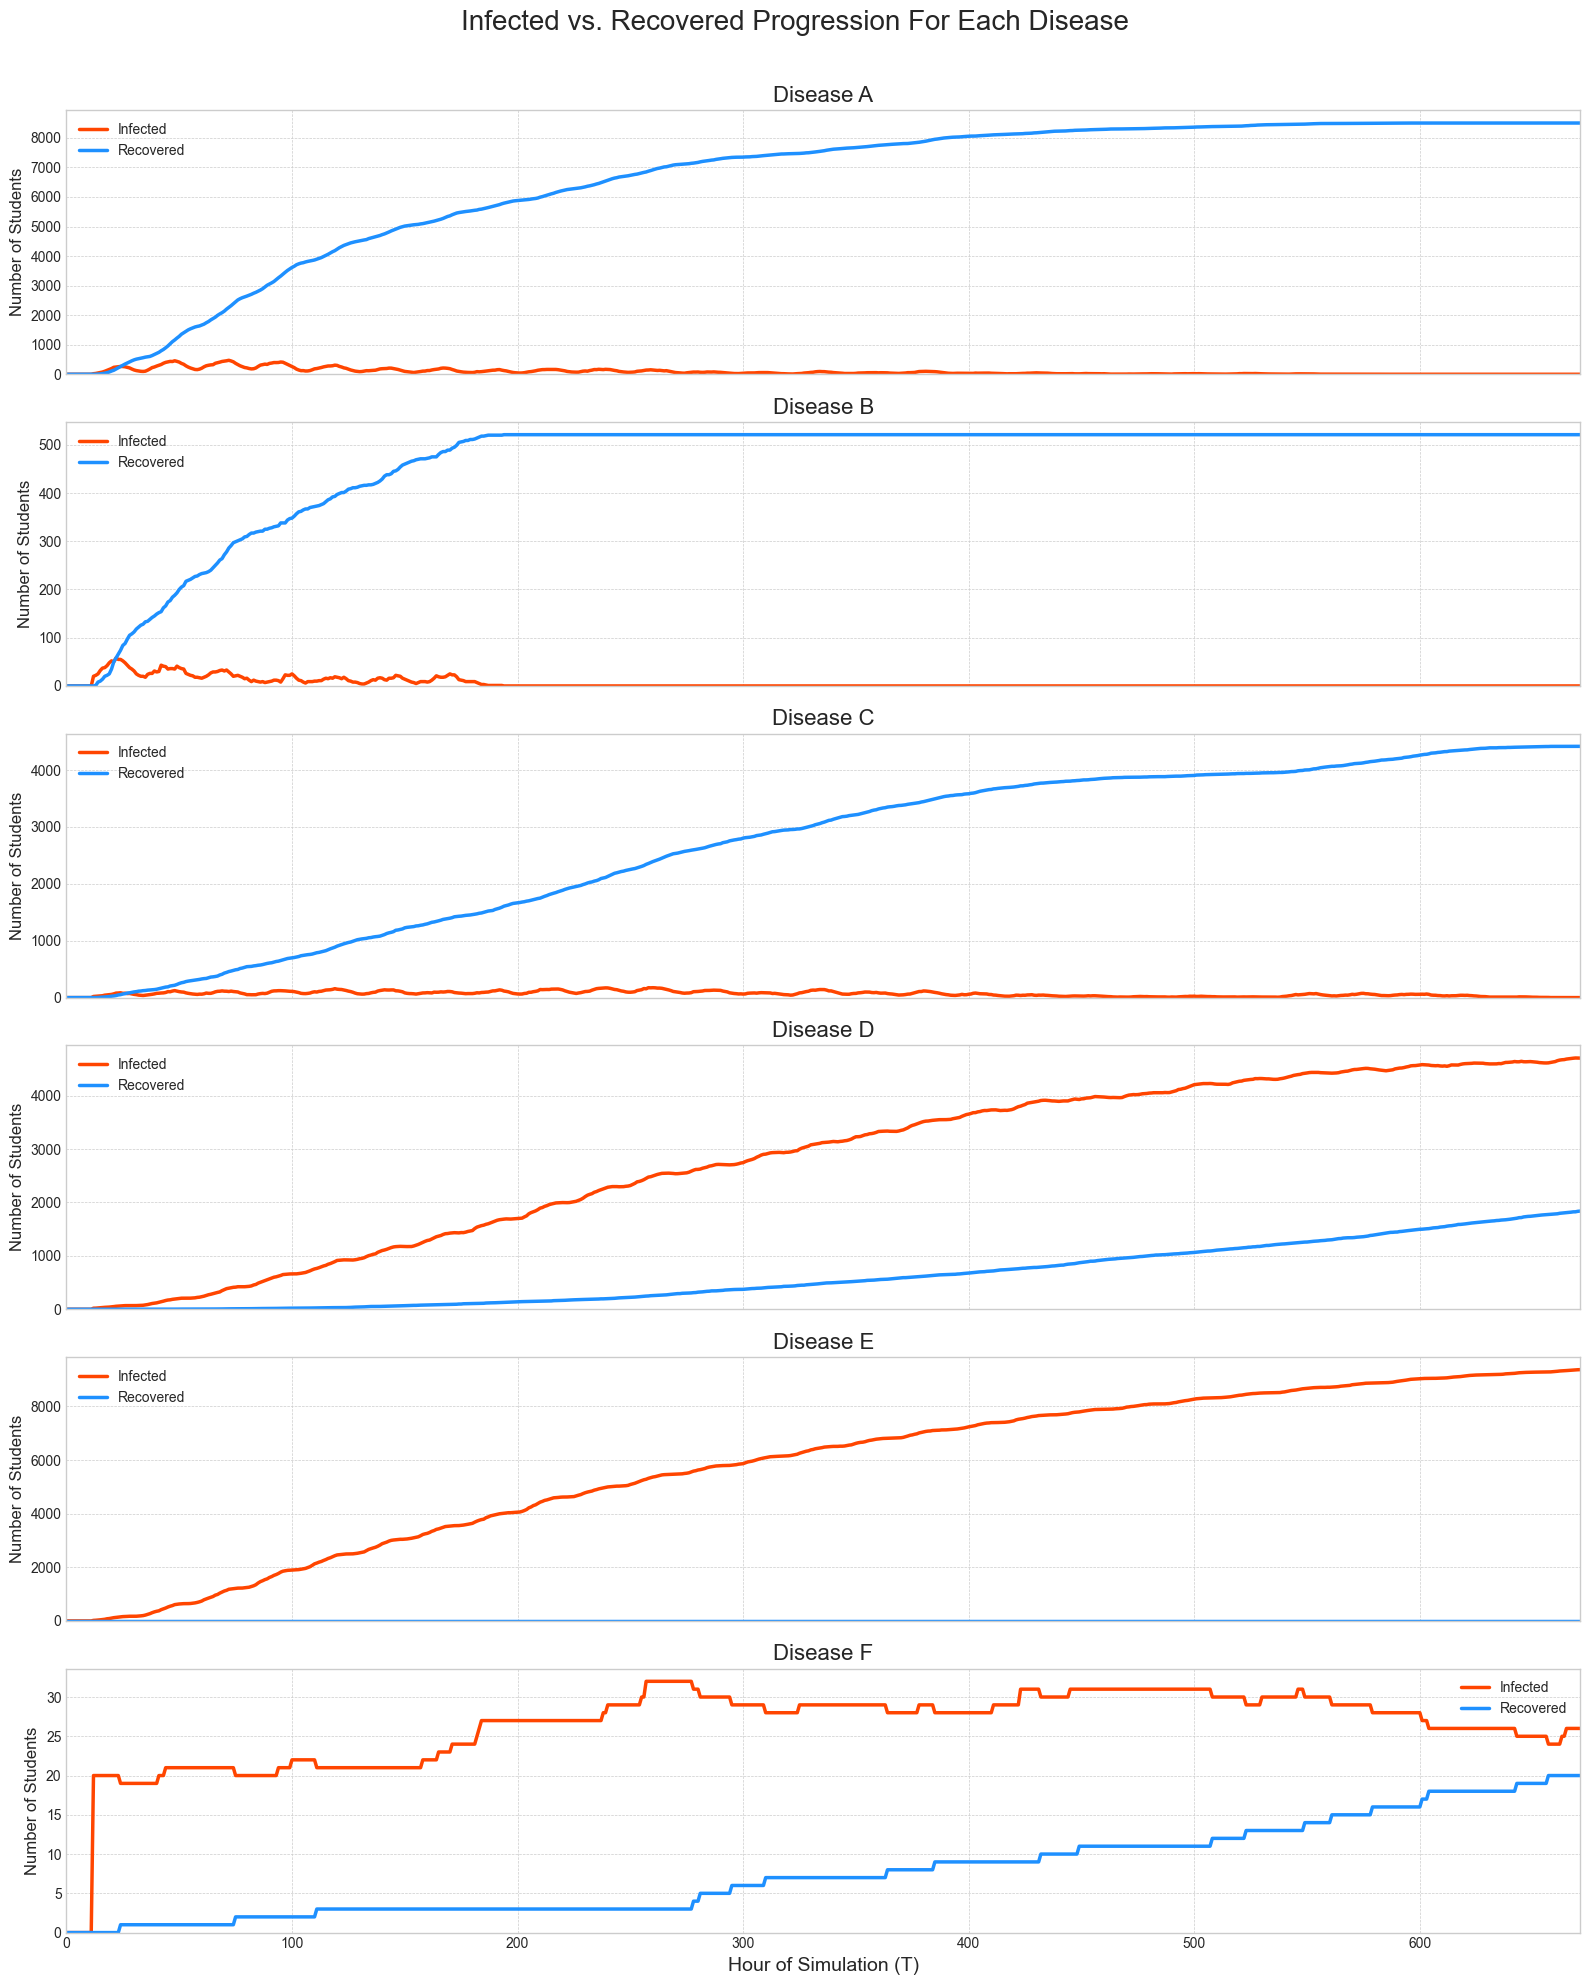

In [149]:
# Specify the path to your completed simulation file
simulation_filepath = 'Disease_track_completeV2.csv'
analyze_and_plot_sir_results(simulation_filepath)

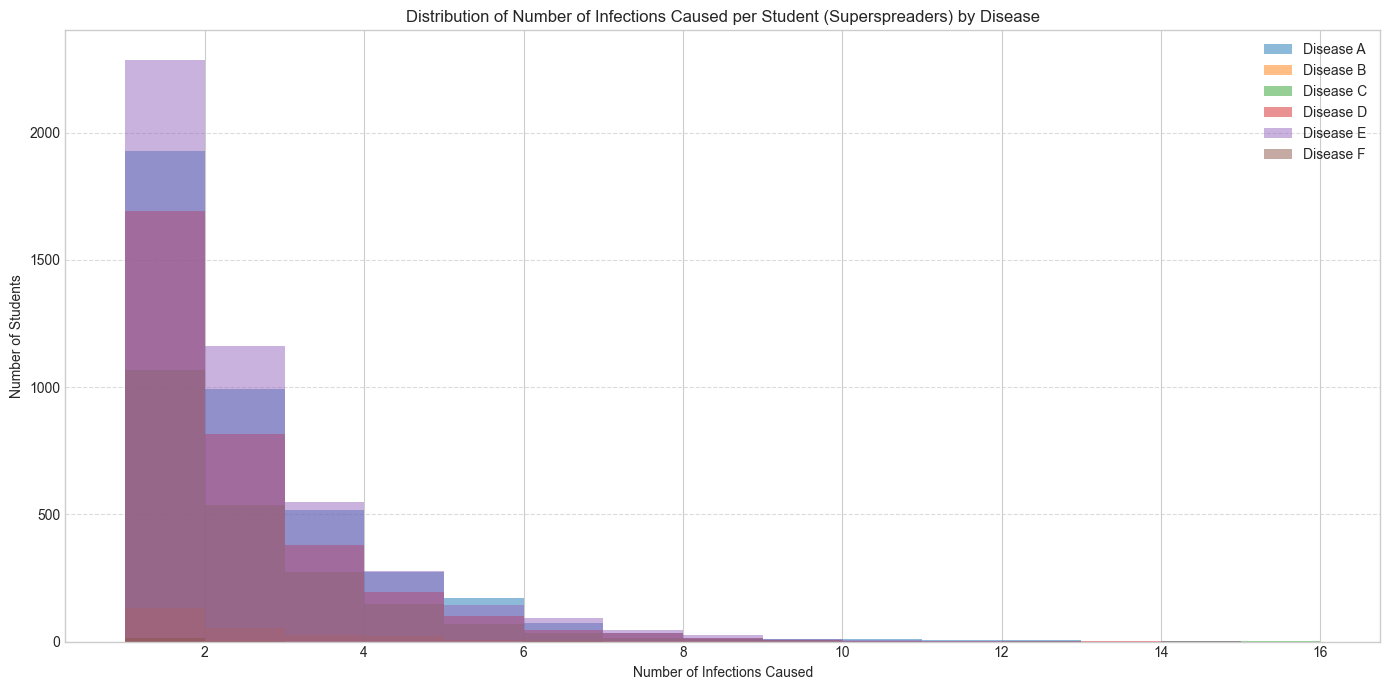

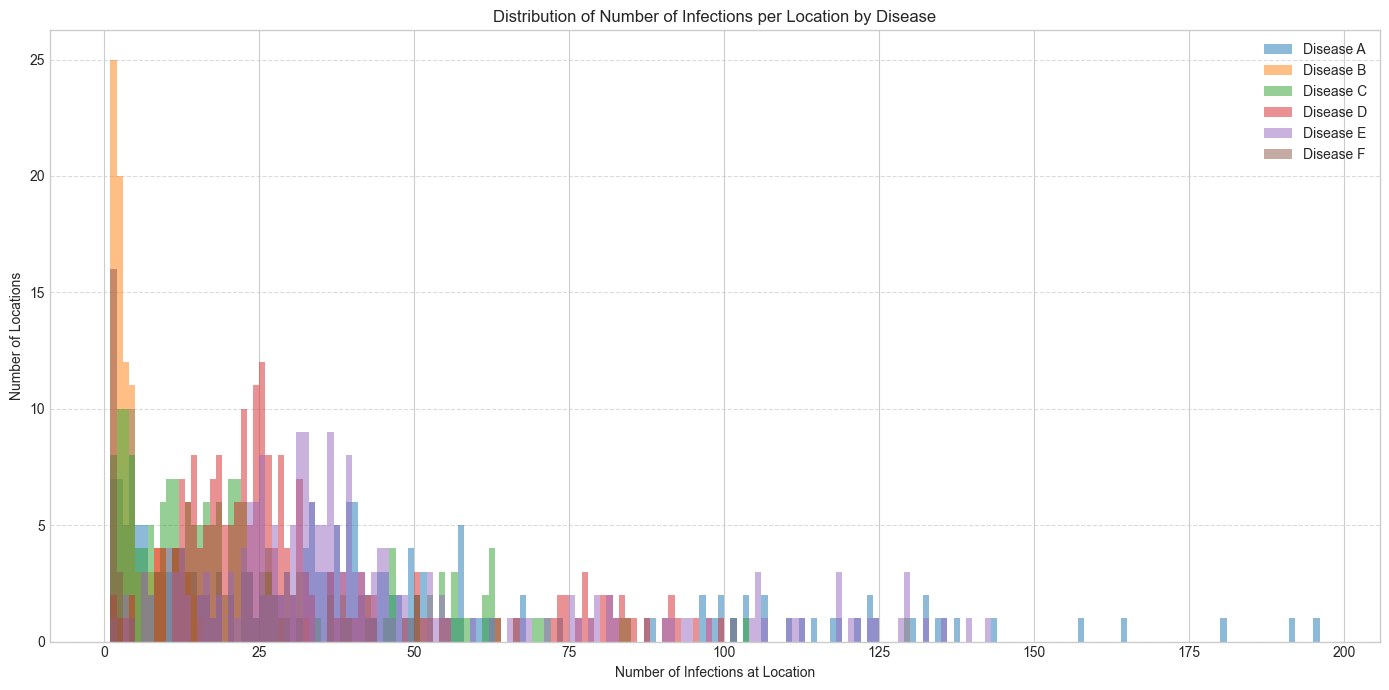


Top 5 superspreaders for Disease A:
source_student
8952    14
4930    12
811     12
1569    12
4182    12
Name: count, dtype: int64

Top 5 transmission locations for Disease A:
location
MASH               195
Lola Lo            191
Revolution         180
Trinity Library    164
Vinyl              157
Name: count, dtype: int64

Top 5 superspreaders for Disease B:
source_student
6801    14
759      8
9455     8
2881     7
3869     7
Name: count, dtype: int64

Top 5 transmission locations for Disease B:
location
Revolution                 32
MASH                       28
Vinyl                      15
Lola Lo                    14
Fitzwilliam College bar    14
Name: count, dtype: int64

Top 5 superspreaders for Disease C:
source_student
270     15
3814    14
5408    12
7493    10
4361    10
Name: count, dtype: int64

Top 5 transmission locations for Disease C:
location
Revolution                129
Lola Lo                   103
MASH                      101
Lucy Cavendish Library     84
Ho

In [150]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the infection events log
infection_log = pd.read_csv('infection_events_log.csv')

# Get unique diseases
diseases = infection_log['disease'].unique()

# --- 1. Superspreader Analysis: Number of infections caused per student, per disease ---
plt.figure(figsize=(14, 7))
for disease in diseases:
    counts = infection_log[infection_log['disease'] == disease]['source_student'].value_counts()
    plt.hist(counts, bins=range(1, counts.max()+2), alpha=0.5, label=f'Disease {disease}')
plt.title('Distribution of Number of Infections Caused per Student (Superspreaders) by Disease')
plt.xlabel('Number of Infections Caused')
plt.ylabel('Number of Students')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 2. Location Analysis: Number of infections per location, per disease ---
plt.figure(figsize=(14, 7))
for disease in diseases:
    loc_counts = infection_log[infection_log['disease'] == disease]['location'].value_counts()
    plt.hist(loc_counts, bins=range(1, loc_counts.max()+2), alpha=0.5, label=f'Disease {disease}')
plt.title('Distribution of Number of Infections per Location by Disease')
plt.xlabel('Number of Infections at Location')
plt.ylabel('Number of Locations')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optionally, print top 5 superspreaders and locations for each disease
for disease in diseases:
    print(f"\nTop 5 superspreaders for Disease {disease}:")
    print(infection_log[infection_log['disease'] == disease]['source_student'].value_counts().head(5))
    print(f"\nTop 5 transmission locations for Disease {disease}:")
    print(infection_log[infection_log['disease'] == disease]['location'].value_counts().head(5))